In [16]:
import sys
sys.path.append('../astro_tools')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from tqdm import tqdm
from astropy.wcs import wcs
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import ImageGrid
from reproject import reproject_interp
from astropy import units as u
from matplotlib.lines import Line2D
from astropy.visualization.wcsaxes import add_beam, add_scalebar
from spectral_cube import SpectralCube

# set up the plot
plt.rcParams['text.usetex'] = False
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.5
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams["font.family"] = "courier new"
plt.rcParams["font.style"] = "normal"
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.weight"] = 'bold'

import warnings
warnings.filterwarnings('ignore')

Set variables.

In [17]:
num_obs = 150
free_params1 = 6
free_params2 = 12
free_params3 = 18
savepath1 = '../ngc253/June21/fits1_total/'
savepath2 = '../ngc253/June21/fits2_total/'
savepath3 = '../ngc253/June21/fits3_total/'
infile1 = '%sfits1_reordered.txt' % savepath1
infile2 = '%sfits2_reordered.txt' % savepath2
infile3 = '%sfits3_reordered.txt' % savepath3
ERRinfile1 = '%sfits1_err_reordered.txt' % savepath1
ERRinfile2 = '%sfits2_err_reordered.txt' % savepath2
ERRinfile3 = '%sfits3_err_reordered.txt' % savepath3

fits1 = pd.read_csv(infile1)
fits2 = pd.read_csv(infile2)
fits3 = pd.read_csv(infile3)
ERRfits1 = pd.read_csv(ERRinfile1)
ERRfits2 = pd.read_csv(ERRinfile2)
ERRfits3 = pd.read_csv(ERRinfile3)

# get info of original data
og = '../ngc253/data/ADP.2018-11-22T21_29_46.157.fits'
hdu = fits.open(og)[1]
og_data = hdu.data
y, x = og_data[1].shape
w = wcs.WCS(hdu.header, naxis=2).celestial

# open the BIC_PHYS test fits file
which_model_infile = '../ngc253/June21/BIC_PHYS_50.fits'
hdu_BIC = fits.open(which_model_infile)
which_model = hdu_BIC[0].data

# open the disk velocity model
disk_map_infile = '../ngc253/data/ngc253_se_halpha_vel_model_smooth_FINAL.fits'
hdu_Ha = fits.open(disk_map_infile)
disk_map = hdu_Ha[0].data

vmin = -300
vmax = 300

Get everything into numpy arrays!

In [18]:
BIC_map1 = np.empty((y,x))
BIC_map2 = np.empty((y,x))
BIC_map3 = np.empty((y,x))
redchisq_map1 = np.empty((y,x))
redchisq_map2 = np.empty((y,x))
redchisq_map3 = np.empty((y,x))
vel_map1 = np.empty((y,x))
vel_map2_b = np.empty((y,x))
vel_map2_r = np.empty((y,x))
vel_map3_b = np.empty((y,x))
vel_map3_0 = np.empty((y,x))
vel_map3_r = np.empty((y,x))
fwhm_map1 = np.empty((y,x))
fwhm_map2_b = np.empty((y,x))
fwhm_map2_r = np.empty((y,x))
fwhm_map3_b = np.empty((y,x))
fwhm_map3_0 = np.empty((y,x))
fwhm_map3_r = np.empty((y,x))

# make maps of the BICs, velocities, and FWHMs
for index, row in fits1.iterrows():
    redchisq_map1[int(row['Y']), int(row['X'])] = row['RedChiSq']
    BIC_map1[int(row['Y']), int(row['X'])] = row['BIC']
    vel_map1[int(row['Y']), int(row['X'])] = row['Vel2']
    fwhm_map1[int(row['Y']), int(row['X'])] = row['SigVel2'] 
for index, row in fits2.iterrows():
    redchisq_map2[int(row['Y']), int(row['X'])] = row['RedChiSq']
    BIC_map2[int(row['Y']), int(row['X'])] = row['BIC']
    vel_map2_b[int(row['Y']), int(row['X'])] = row['Vel3']
    vel_map2_r[int(row['Y']), int(row['X'])] = row['Vel4']
    fwhm_map2_b[int(row['Y']), int(row['X'])] = row['SigVel3']
    fwhm_map2_r[int(row['Y']), int(row['X'])] = row['SigVel4']
for index, row in fits3.iterrows():
    redchisq_map3[int(row['Y']), int(row['X'])] = row['RedChiSq']
    BIC_map3[int(row['Y']), int(row['X'])] = row['BIC']
    vel_map3_b[int(row['Y']), int(row['X'])] = row['Vel4']
    vel_map3_0[int(row['Y']), int(row['X'])] = row['Vel5']
    vel_map3_r[int(row['Y']), int(row['X'])] = row['Vel6']
    fwhm_map3_b[int(row['Y']), int(row['X'])] = row['SigVel4']
    fwhm_map3_0[int(row['Y']), int(row['X'])] = row['SigVel5']
    fwhm_map3_r[int(row['Y']), int(row['X'])] = row['SigVel6']

# blank out edges
BIC_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
BIC_map2[np.isnan(og_data[1])] = np.nan # [0] has some nans within
BIC_map3[np.isnan(og_data[1])] = np.nan # [0] has some nans within
redchisq_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
redchisq_map2[np.isnan(og_data[1])] = np.nan # [0] has some nans within
redchisq_map3[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map2_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map2_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map3_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map3_0[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map3_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
fwhm_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
fwhm_map2_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
fwhm_map2_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
fwhm_map3_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
fwhm_map3_0[np.isnan(og_data[1])] = np.nan # [0] has some nans within
fwhm_map3_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within





In [19]:
ERRvel_map1 = np.empty((y,x))
ERRvel_map2_b = np.empty((y,x))
ERRvel_map2_r = np.empty((y,x))
ERRvel_map3_b = np.empty((y,x))
ERRvel_map3_0 = np.empty((y,x))
ERRvel_map3_r = np.empty((y,x))

for index, row in ERRfits1.iterrows():
    ERRvel_map1[int(row['Y']), int(row['X'])] = row['Vel2'] * row['rms']  # estimated error
for index, row in ERRfits2.iterrows():
    ERRvel_map2_b[int(row['Y']), int(row['X'])] = row['Vel3'] * row['rms']
    ERRvel_map2_r[int(row['Y']), int(row['X'])] = row['Vel4'] * row['rms']
for index, row in ERRfits3.iterrows():
    ERRvel_map3_b[int(row['Y']), int(row['X'])] = row['Vel4'] * row['rms']
    ERRvel_map3_0[int(row['Y']), int(row['X'])] = row['Vel5'] * row['rms']
    ERRvel_map3_r[int(row['Y']), int(row['X'])] = row['Vel6'] * row['rms']
    
ERRvel_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
ERRvel_map2_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
ERRvel_map2_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
ERRvel_map3_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
ERRvel_map3_0[np.isnan(og_data[1])] = np.nan # [0] has some nans within
ERRvel_map3_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within

What is the distribution of BIC and reduced chi square values for the one, two, and three component fits?

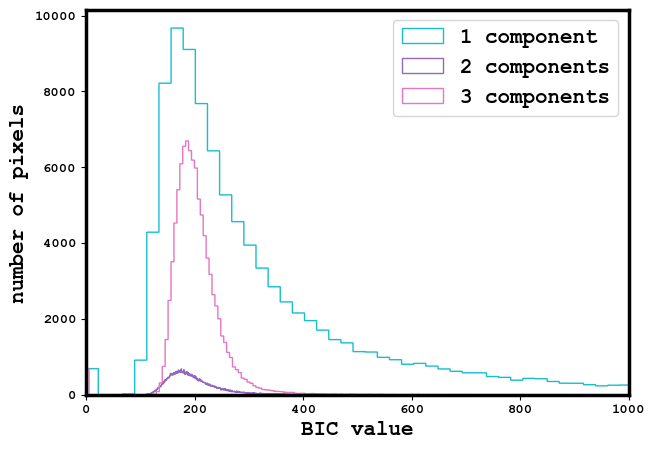

In [20]:
plt.figure(figsize=(7,5))
plt.hist(BIC_map1.flatten(), bins=10000, label='1 component', color='tab:cyan', histtype='step')
plt.hist(BIC_map2.flatten(), bins=10000, label='2 components', color='tab:purple', histtype='step')
plt.hist(BIC_map3.flatten(), bins=10000, label='3 components', color='tab:pink', histtype='step')
plt.xlim(0,1000)
plt.legend(fontsize=15, loc='upper right')
plt.xlabel('BIC value', fontsize=15)
plt.ylabel('number of pixels', fontsize=15)
plt.savefig('../ngc253/visuals/BIC_dist.png', dpi=300)
plt.show()

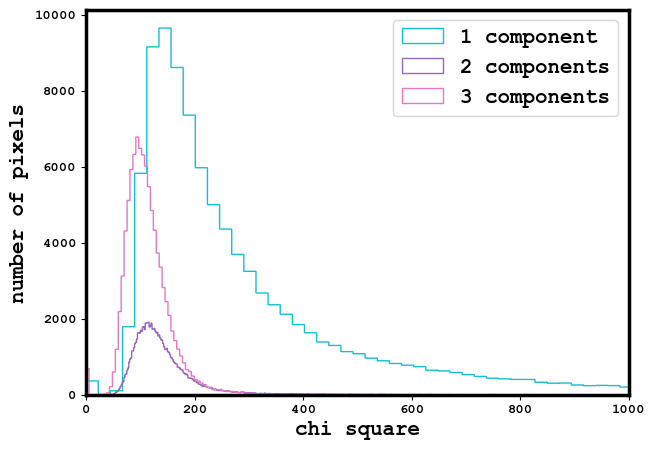

In [21]:
num_obs = 150
free_params1 = 6
free_params2 = 12
free_params3 = 18

redchisq1 = redchisq_map1.flatten() * (num_obs - free_params1)
redchisq2 = redchisq_map2.flatten() * (num_obs - free_params2)
redchisq3 = redchisq_map3.flatten() * (num_obs - free_params3)


plt.figure(figsize=(7,5))
plt.hist(redchisq1, bins=10000, label='1 component', color='tab:cyan', histtype='step')
plt.hist(redchisq2, bins=10000, label='2 components', color='tab:purple', histtype='step')
plt.hist(redchisq3, bins=10000, label='3 components', color='tab:pink', histtype='step')
plt.xlim(0,1000)
plt.legend(fontsize=15, loc='upper right')
plt.xlabel('chi square', fontsize=15)
plt.ylabel('number of pixels', fontsize=15)
plt.savefig('../ngc253/visuals/chisq_dist.png', dpi=300)
plt.show()

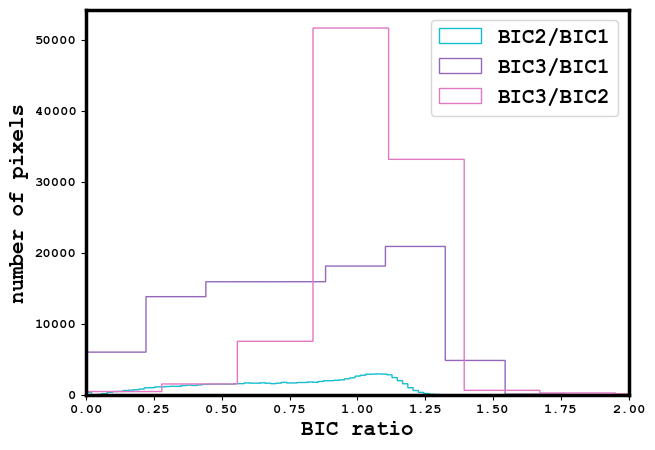

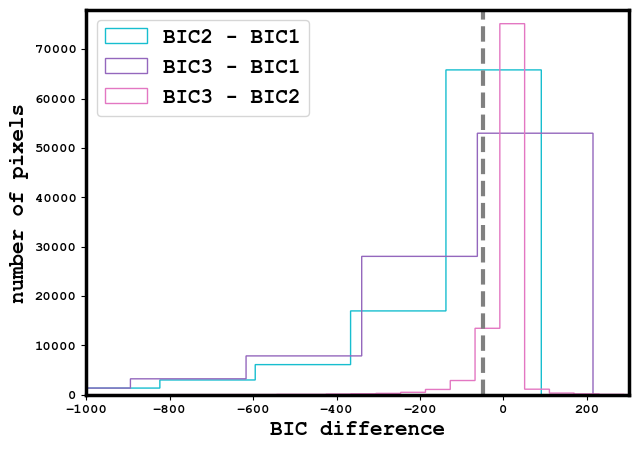

In [22]:
ratio1 = (BIC_map2 / BIC_map1).flatten()[np.isfinite((BIC_map2 / BIC_map1).flatten())]
ratio2 = (BIC_map3 / BIC_map1).flatten()[np.isfinite((BIC_map3 / BIC_map1).flatten())]
ratio3 = (BIC_map3 / BIC_map2).flatten()[np.isfinite((BIC_map3 / BIC_map2).flatten())]

plt.figure(figsize=(7,5))
plt.hist(ratio1, bins=1000, label='BIC2/BIC1', color='tab:cyan', histtype='step')
plt.hist(ratio2, bins=1000, label='BIC3/BIC1', color='tab:purple', histtype='step')
plt.hist(ratio3, bins=1000, label='BIC3/BIC2', color='tab:pink', histtype='step')
plt.xlim(0,2)
plt.legend(fontsize=15, loc='upper right')
plt.xlabel('BIC ratio', fontsize=15)
plt.ylabel('number of pixels', fontsize=15)
# plt.savefig('../ngc253/visuals/BIC_ratio_dist.png', dpi=300)
plt.show()

diff1 = (BIC_map2 - BIC_map1).flatten()[np.isfinite((BIC_map2 - BIC_map1).flatten())]
diff2 = (BIC_map3 - BIC_map1).flatten()[np.isfinite((BIC_map3 - BIC_map1).flatten())]
diff3 = (BIC_map3 - BIC_map2).flatten()[np.isfinite((BIC_map3 - BIC_map2).flatten())]

plt.figure(figsize=(7,5))
plt.hist(diff1, bins=1000, label='BIC2 - BIC1', color='tab:cyan', histtype='step')
plt.hist(diff2, bins=1000, label='BIC3 - BIC1', color='tab:purple', histtype='step')
plt.hist(diff3, bins=1000, label='BIC3 - BIC2', color='tab:pink', histtype='step')
plt.xlim(-1000,300)
plt.ylim(top=78000)
plt.vlines(x=-50, ymin=0, ymax=78000, color='gray', ls='--', lw=3)
plt.legend(fontsize=15, loc='upper left')
plt.xlabel('BIC difference', fontsize=15)
plt.ylabel('number of pixels', fontsize=15)
plt.savefig('../ngc253/visuals/BIC_diff_dist.png', dpi=300)
plt.show()

In [23]:
dBIC_thresh = -50
BIC_PHYS = np.full((y,x), 1.0)  # assume 1 is the best
BIC_PHYS[((BIC_map2 - BIC_map1) < dBIC_thresh)] = 2   # assume 2 is the second best
BIC_PHYS[((BIC_map3 - BIC_map2) < dBIC_thresh)] = 3   # assume 3 is the third best

In [24]:
# DOF = num_obs - free_params  # number of observed points - free parameters
new1 = 1.98 * (150-6) + 6*np.log(150)
new2 = 1.86 * (150-12) + 12*np.log(150)
new3 = 1.64 * (150-18) + 18*np.log(150)
print(new1)
print(new2)
print(new3)
print('----------')
print(new2 - new1, new2/new1)
print(new3 - new1, new3/new1)
print(new3 - new2, new3/new2)
print('----------')
print(BIC_map1[165,360])
print(BIC_map2[165,360])
print(BIC_map3[165,360])
print('----------')
print(BIC_map2[165,360] - BIC_map1[165,360])
print(BIC_map3[165,360] - BIC_map1[165,360])
print(BIC_map3[165,360] - BIC_map2[165,360])

315.1838117645775
316.8076235291551
306.6714352937326
----------
1.6238117645775674 1.005151951667462
-8.512376470844913 0.9729923423947828
-10.13618823542248 0.9680052262552651
----------
125.16141176457754
147.71622352915506
174.96183529373258
----------
22.554811764577522
49.80042352915504
27.245611764577518


- Splitting things up based on redshift vs blueshift.
- Disk is 1 system of Gaussians and the red component of the 2 system fit and 3 system fit
- Outflow #1 is the blue component of 2 and 3
- Outflow #2 is the second red component of 3

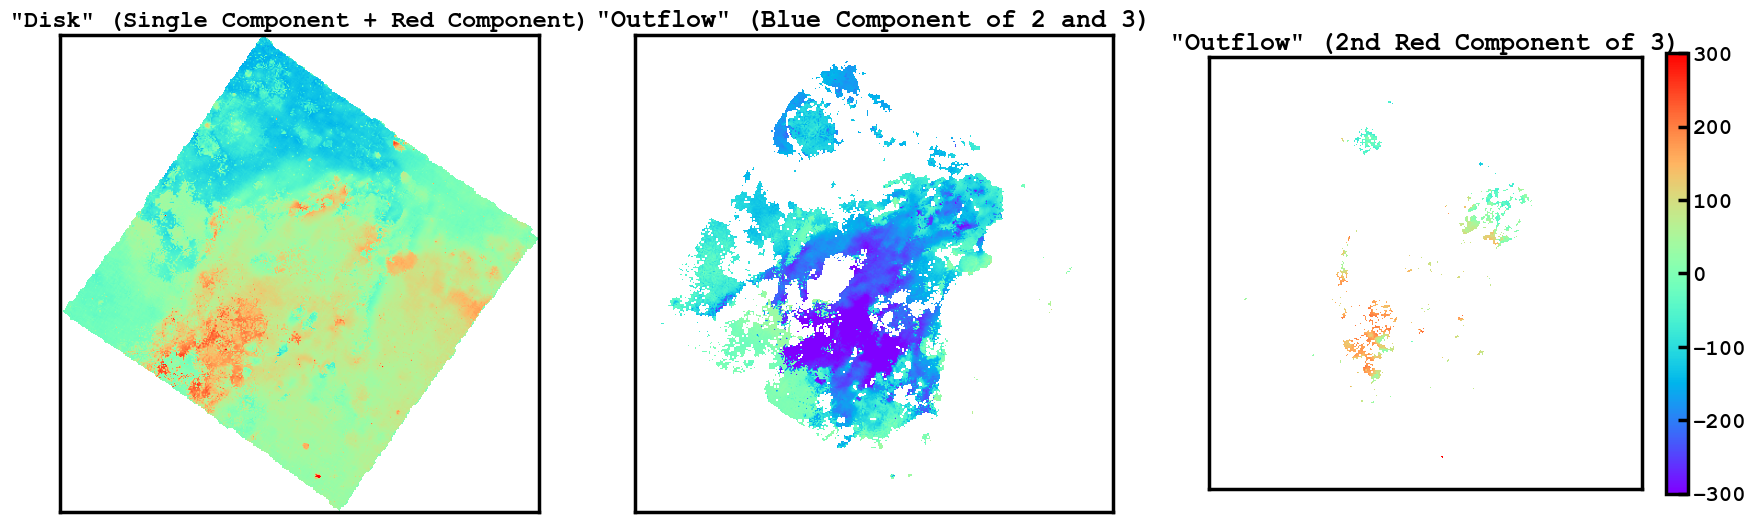

In [25]:
outflow1_vel = np.full((y,x), np.nan)
disk_vel = np.full((y,x), np.nan)
outflow2_vel = np.full((y,x), np.nan)

disk_vel[which_model == 1.] = vel_map1[which_model == 1.]
disk_vel[which_model == 2.] = vel_map2_r[which_model == 2.]
disk_vel[which_model == 3.] = vel_map3_r[which_model == 3.]

outflow1_vel[which_model == 2.] = vel_map2_b[which_model == 2.]
outflow1_vel[which_model == 3.] = vel_map3_b[which_model == 3.]

outflow2_vel[which_model == 3.] = vel_map3_r[which_model == 3.]

# and plot

plt.figure(figsize=(21,7))
ax = plt.subplot(1, 3, 1)
im = ax.imshow(disk_vel, vmin=vmin, vmax=vmax, origin='lower', cmap='rainbow')
ax.set_title('"Disk" (Single Component + Red Component)', fontsize=17)
ax.set_xticks([])
ax.set_yticks([])

ax = plt.subplot(1, 3, 2)
im = ax.imshow(outflow1_vel, origin='lower', vmin=vmin, vmax=vmax, cmap='rainbow')
ax.set_title('"Outflow" (Blue Component of 2 and 3)', fontsize=18)
ax.set_xticks([])
ax.set_yticks([])

ax = plt.subplot(1, 3, 3)
im = ax.imshow(outflow2_vel, origin='lower', vmin=vmin, vmax=vmax, cmap='rainbow')
ax.set_title('"Outflow" (2nd Red Component of 3)', fontsize=18)
ax.set_xticks([])
ax.set_yticks([])

bar = plt.colorbar(im, fraction=0.046)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')
plt.show()



- Splitting things up based on velocities

In [26]:
# blueshifted 2 component model
mask2_b = ((np.abs(vel_map2_b - disk_map) < np.abs(vel_map2_r - disk_map)))

# redshifted 2 component model
mask2_r = ((np.abs(vel_map2_r - disk_map) < np.abs(vel_map2_b - disk_map)))

# blueshifted 3 component model
mask3_b = ((np.abs(vel_map3_b - disk_map) < np.abs(vel_map3_r - disk_map)) & \
          (np.abs(vel_map3_b - disk_map) < np.abs(vel_map3_0 - disk_map)))

# middle 3 component model
mask3_0 = ((np.abs(vel_map3_0 - disk_map) < np.abs(vel_map3_b - disk_map)) & \
          (np.abs(vel_map3_0 - disk_map) < np.abs(vel_map3_r - disk_map)))

# redshifted 3 component model
mask3_r = ((np.abs(vel_map3_r - disk_map) < np.abs(vel_map3_b - disk_map)) & \
          (np.abs(vel_map3_r - disk_map) < np.abs(vel_map3_0 - disk_map)))

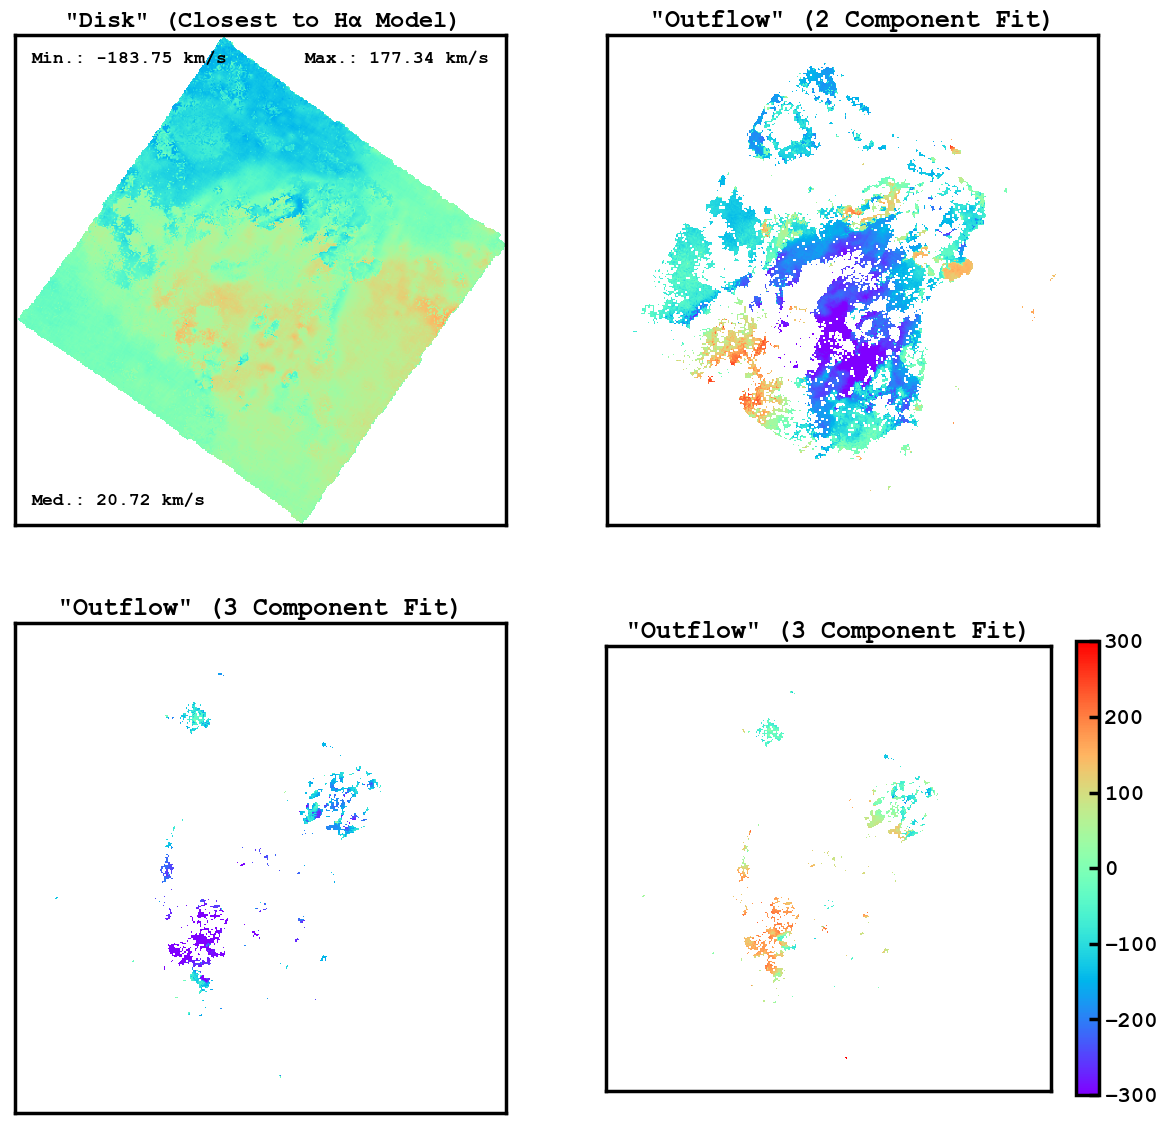

In [27]:
plt.figure(figsize=(14,14))

outflow1_vel = np.full((y,x), np.nan)
disk_vel = np.full((y,x), np.nan)
outflow2_vel = np.full((y,x), np.nan)
outflow3_vel = np.full((y,x), np.nan)

# DISK
disk_vel[which_model == 1.] = vel_map1[which_model == 1.]  # assume 1 is disk
disk_vel[(which_model == 2.) & mask2_b] = vel_map2_b[(which_model == 2.) & mask2_b]
disk_vel[(which_model == 2.) & mask2_r] = vel_map2_r[(which_model == 2.) & mask2_r]
disk_vel[(which_model == 3.) & mask3_b] = vel_map3_b[(which_model == 3.) & mask3_b]
disk_vel[(which_model == 3.) & mask3_0] = vel_map3_0[(which_model == 3.) & mask3_0]
disk_vel[(which_model == 3.) & mask3_r] = vel_map3_r[(which_model == 3.) & mask3_r]

ax = plt.subplot(2, 2, 1)
im = ax.imshow(disk_vel, vmin=vmin, vmax=vmax, origin='lower', cmap='rainbow')
ax.set_title('"Disk" (Closest to H$\\alpha$ Model)', fontsize=17)

min_disk = round(np.min(disk_vel[np.isfinite(disk_vel)]),2)
max_disk = round(np.max(disk_vel[np.isfinite(disk_vel)]),2)
med_disk = round(np.median(disk_vel[np.isfinite(disk_vel)]),2)

at = AnchoredText('Min.: %s km/s' % (min_disk), prop=dict(size=13), frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
at = AnchoredText('Max.: %s km/s' % (max_disk), prop=dict(size=13), frameon=False, loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
at = AnchoredText('Med.: %s km/s' % (med_disk), prop=dict(size=13), frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

ax.set_xticks([])
ax.set_yticks([])

# 2 COMPONENT FIT OUTFLOW
outflow1_vel[(which_model == 2.) & mask2_b] = vel_map2_r[(which_model == 2.) & mask2_b]
outflow1_vel[(which_model == 2.) & mask2_r] = vel_map2_b[(which_model == 2.) & mask2_r]

ax = plt.subplot(2, 2, 2)
im = ax.imshow(outflow1_vel, origin='lower', vmin=vmin, vmax=vmax, cmap='rainbow')
ax.set_title('"Outflow" (2 Component Fit)', fontsize=18)
ax.set_xticks([])
ax.set_yticks([])

# 3 COMPONENT FIT OUTFLOW, MORE BLUESHIFTED COMPONENT
outflow2_vel[(which_model == 3.) & mask3_b] = vel_map3_0[(which_model == 3.) & mask3_b]  # disk is blue
outflow2_vel[(which_model == 3.) & mask3_r] = vel_map3_b[(which_model == 3.) & mask3_r]  # disk is red
outflow2_vel[(which_model == 3.) & mask3_0] = vel_map3_b[(which_model == 3.) & mask3_0]  # disk is 0

ax = plt.subplot(2, 2, 3)
im = ax.imshow(outflow2_vel, origin='lower', vmin=vmin, vmax=vmax, cmap='rainbow')
ax.set_title('"Outflow" (3 Component Fit)', fontsize=18)
ax.set_xticks([])
ax.set_yticks([])

# 3 COMPONENT FIT OUTFLOW, MORE REDSHIFTED COMPONENT
outflow3_vel[(which_model == 3.) & mask3_b] = vel_map3_r[(which_model == 3.) & mask3_b]  # disk is blue
outflow3_vel[(which_model == 3.) & mask3_r] = vel_map3_0[(which_model == 3.) & mask3_r]  # disk is red
outflow3_vel[(which_model == 3.) & mask3_0] = vel_map3_r[(which_model == 3.) & mask3_0]  # disk is 0

ax = plt.subplot(2, 2, 4)
im = ax.imshow(outflow3_vel, origin='lower', vmin=vmin, vmax=vmax, cmap='rainbow')
ax.set_title('"Outflow" (3 Component Fit)', fontsize=18)
ax.set_xticks([])
ax.set_yticks([])

bar = plt.colorbar(im, fraction=0.046)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')
plt.show()

In [28]:
# anchored text font
Afont = {
        'family' : 'courier new',
        'color':  'white',
        'size': 12,
        }

Afont_labels = {
        'family' : 'courier new',
        'color':  'white',
        'size': 15,
        }

Afont_labels1 = {
        'family' : 'courier new',
        'color':  'black',
        'size': 15,
        }

# scalebar font
SBfont = {
        'family' : 'courier new',
        'size': 14,
        }

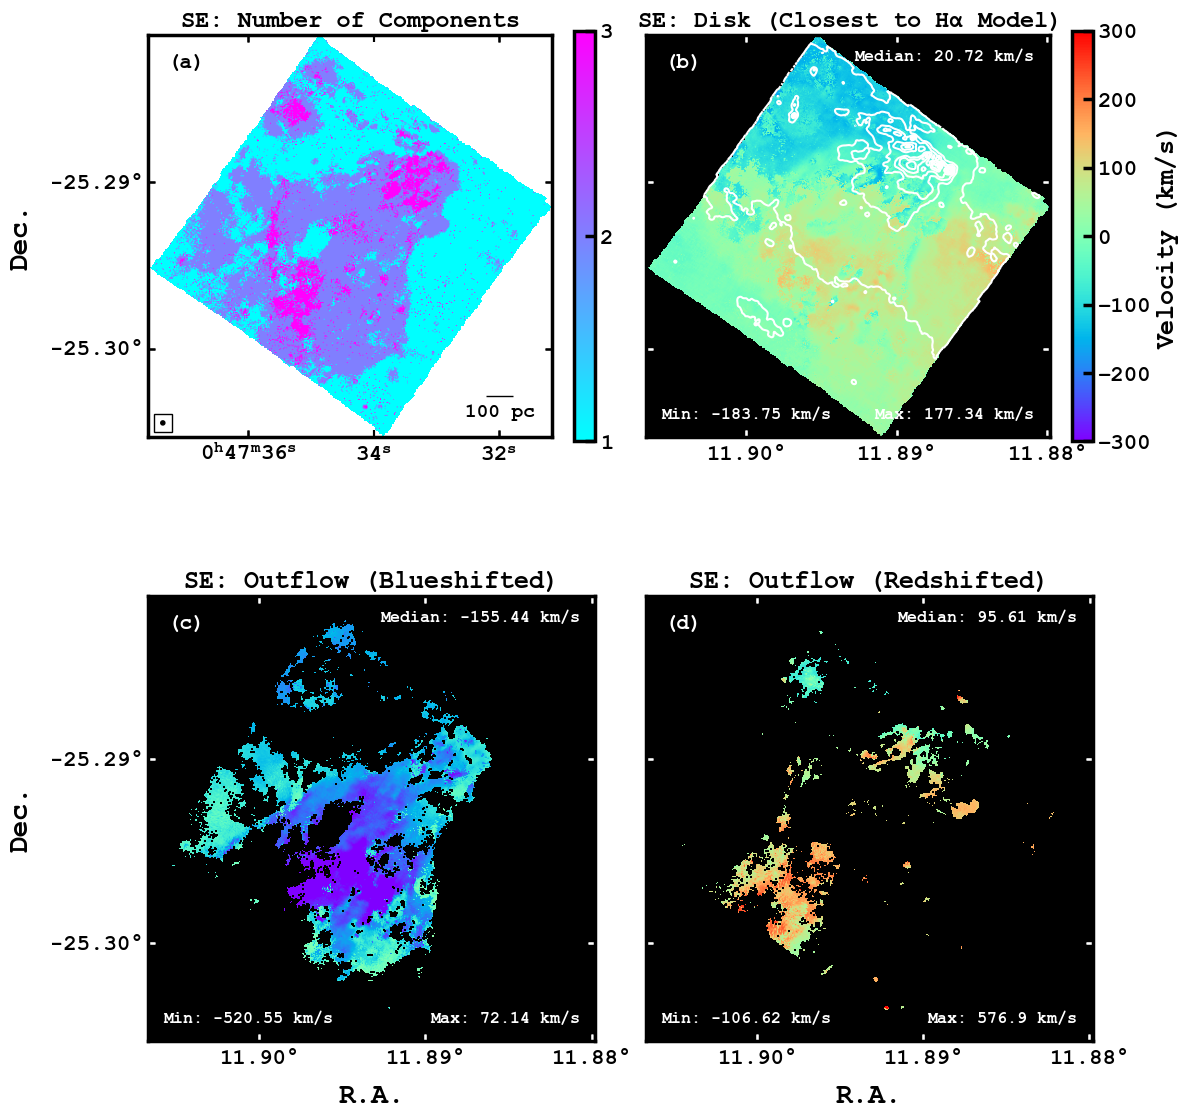

In [29]:
plt.figure(figsize=(12,12))

outflow1_vel = np.full((y,x), np.nan)
disk_vel = np.full((y,x), np.nan)
outflow2_vel = np.full((y,x), np.nan)

ax = plt.subplot(2, 2, 1, projection=w)
im = ax.imshow(which_model, origin='lower', cmap='cool')
ax.coords[1].set_major_formatter('d.dd')
ax.set_title('SE: Number of Components', fontsize=17)
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='black')
ax.coords[0].set_auto_axislabel(False)
ax.set_ylabel('Dec.', fontsize=20)
bar = plt.colorbar(im, fraction=0.046)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')
bar.ax.locator_params(nbins=3)

# add a scale bar
distance = 3.5 * u.Mpc
scalebar_length = 100 * u.pc
scalebar_angle = (scalebar_length / distance).to(u.deg, equivalencies=u.dimensionless_angles())
add_scalebar(ax, scalebar_angle, label="100 pc", fontproperties=SBfont, corner='bottom right')
add_beam(ax, major=0.89 * u.arcsec, minor=0.89 * u.arcsec, angle=0, frame=True, color='black')

at = AnchoredText('(a)', prop=Afont_labels1, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

# DISK
disk_vel[which_model == 1.] = vel_map1[which_model == 1.]  # assume 1 is disk
disk_vel[(which_model == 2.) & mask2_b] = vel_map2_b[(which_model == 2.) & mask2_b]
disk_vel[(which_model == 2.) & mask2_r] = vel_map2_r[(which_model == 2.) & mask2_r]
disk_vel[(which_model == 3.) & mask3_b] = vel_map3_b[(which_model == 3.) & mask3_b]
disk_vel[(which_model == 3.) & mask3_0] = vel_map3_0[(which_model == 3.) & mask3_0]
disk_vel[(which_model == 3.) & mask3_r] = vel_map3_r[(which_model == 3.) & mask3_r]

ax = plt.subplot(2, 2, 2, projection=w)
im = ax.imshow(disk_vel, vmin=vmin, vmax=vmax, origin='lower', cmap='rainbow')
ax.coords[0].set_major_formatter('d.dd')
ax.coords[1].set_major_formatter('d.dd')
ax.set_title('SE: Disk (Closest to H$\\alpha$ Model)', fontsize=17)
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='white')
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
ax.coords[1].set_ticklabel_visible(False)

min_disk = round(np.min(disk_vel[np.isfinite(disk_vel)]),2)
max_disk = round(np.max(disk_vel[np.isfinite(disk_vel)]),2)
med_disk = round(np.median(disk_vel[np.isfinite(disk_vel)]),2)

at = AnchoredText('Min: %s km/s' % (min_disk), prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
at = AnchoredText('Max: %s km/s' % (max_disk), prop=Afont, frameon=False, loc='lower right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
at = AnchoredText('Median: %s km/s' % (med_disk), prop=Afont, frameon=False, loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
at = AnchoredText('(b)', prop=Afont_labels, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

bar = plt.colorbar(im, fraction=0.046)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')
bar.set_label('Velocity (km/s)', fontsize=18)
ax.set_facecolor("black")

# contours to show brightness
og_SpecCube = SpectralCube.read('../ngc253/data/ADP.2018-11-22T21_29_46.157.fits', hdu=1)
og_mom0 = og_SpecCube.moment(order=0)  # moment 0
contours = ax.contour(og_mom0, 8, colors='white')
# ax.clabel(contours, fontsize=15, inline=True)

# BLUESHIFTED OUTFLOW
outflow1_vel[(which_model == 2.) & mask2_r] = vel_map2_b[(which_model == 2.) & mask2_r]
outflow1_vel[(which_model == 3.) & mask3_r] = vel_map3_b[(which_model == 3.) & mask3_r]
outflow1_vel[(which_model == 3.) & mask3_0] = vel_map3_b[(which_model == 3.) & mask3_0]

ax = plt.subplot(2, 2, 3, projection=w)
im = ax.imshow(outflow1_vel, origin='lower', vmin=vmin, vmax=vmax, cmap='rainbow')
ax.set_title('SE: Outflow (Blueshifted)', fontsize=18)
ax.coords[0].set_major_formatter('d.dd')
ax.coords[1].set_major_formatter('d.dd')
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='white')
ax.set_xlabel('R.A.', fontsize=20)
ax.set_ylabel('Dec.', fontsize=20)

min_disk = round(np.min(outflow1_vel[np.isfinite(outflow1_vel)]),2)
max_disk = round(np.max(outflow1_vel[np.isfinite(outflow1_vel)]),2)
med_disk = round(np.median(outflow1_vel[np.isfinite(outflow1_vel)]),2)

at = AnchoredText('Min: %s km/s' % (min_disk), prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
at = AnchoredText('Max: %s km/s' % (max_disk), prop=Afont, frameon=False, loc='lower right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
at = AnchoredText('Median: %s km/s' % (med_disk), prop=Afont, frameon=False, loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
at = AnchoredText('(c)', prop=Afont_labels, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

ax.set_facecolor("black")

# REDSHIFTED OUTFLOW
outflow2_vel[(which_model == 2.) & mask2_b] = vel_map2_r[(which_model == 2.) & mask2_b]
outflow2_vel[(which_model == 3.) & mask3_b] = vel_map3_r[(which_model == 3.) & mask3_b]
outflow2_vel[(which_model == 3.) & mask3_0] = vel_map3_r[(which_model == 3.) & mask3_0]

ax = plt.subplot(2, 2, 4, projection=w)
im = ax.imshow(outflow2_vel, origin='lower', vmin=vmin, vmax=vmax, cmap='rainbow')
ax.set_title('SE: Outflow (Redshifted)', fontsize=18)
ax.coords[0].set_major_formatter('d.dd')
ax.coords[1].set_major_formatter('d.dd')
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='white')
ax.set_xlabel('R.A.', fontsize=20)
ax.coords[1].set_auto_axislabel(False)
ax.coords[1].set_ticklabel_visible(False)

min_disk = round(np.min(outflow2_vel[np.isfinite(outflow2_vel)]),2)
max_disk = round(np.max(outflow2_vel[np.isfinite(outflow2_vel)]),2)
med_disk = round(np.median(outflow2_vel[np.isfinite(outflow2_vel)]),2)

at = AnchoredText('Min: %s km/s' % (min_disk), prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
at = AnchoredText('Max: %s km/s' % (max_disk), prop=Afont, frameon=False, loc='lower right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
at = AnchoredText('Median: %s km/s' % (med_disk), prop=Afont, frameon=False, loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
at = AnchoredText('(d)', prop=Afont_labels, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

ax.set_facecolor("black")

plt.tight_layout()
plt.savefig('../ngc253/visuals/se_vels.png', dpi=300)
plt.show()

In [31]:
# grab the error
hdr = w.to_header()
ERRoutflow1_vel = np.full((y,x), np.nan)
ERRdisk_vel = np.full((y,x), np.nan)
ERRoutflow2_vel = np.full((y,x), np.nan)

ERRdisk_vel[which_model == 1.] = ERRvel_map1[which_model == 1.]  # assume 1 is disk
ERRdisk_vel[(which_model == 2.) & mask2_b] = ERRvel_map2_b[(which_model == 2.) & mask2_b]
ERRdisk_vel[(which_model == 2.) & mask2_r] = ERRvel_map2_r[(which_model == 2.) & mask2_r]
ERRdisk_vel[(which_model == 3.) & mask3_b] = ERRvel_map3_b[(which_model == 3.) & mask3_b]
ERRdisk_vel[(which_model == 3.) & mask3_0] = ERRvel_map3_0[(which_model == 3.) & mask3_0]
ERRdisk_vel[(which_model == 3.) & mask3_r] = ERRvel_map3_r[(which_model == 3.) & mask3_r]

ERRoutflow1_vel[(which_model == 2.) & mask2_r] = ERRvel_map2_b[(which_model == 2.) & mask2_r]
ERRoutflow1_vel[(which_model == 3.) & mask3_r] = ERRvel_map3_b[(which_model == 3.) & mask3_r]
ERRoutflow1_vel[(which_model == 3.) & mask3_0] = ERRvel_map3_b[(which_model == 3.) & mask3_0]

ERRoutflow2_vel[(which_model == 2.) & mask2_b] = ERRvel_map2_r[(which_model == 2.) & mask2_b]
ERRoutflow2_vel[(which_model == 3.) & mask3_b] = ERRvel_map3_r[(which_model == 3.) & mask3_b]
ERRoutflow2_vel[(which_model == 3.) & mask3_0] = ERRvel_map3_r[(which_model == 3.) & mask3_0]

hdul = fits.PrimaryHDU(data=ERRdisk_vel, header=hdr)
hdul.writeto('../ngc253/data/output_maps/ngc253_muse_se_ha_vel_disk_ERR.fits',  overwrite=True)

hdul = fits.PrimaryHDU(data=ERRoutflow1_vel, header=hdr)
hdul.writeto('../ngc253/data/output_maps/ngc253_muse_se_ha_vel_outflow_blue_ERR.fits',  overwrite=True)

hdul = fits.PrimaryHDU(data=ERRoutflow2_vel, header=hdr)
hdul.writeto('../ngc253/data/output_maps/ngc253_muse_se_ha_vel_outflow_red_ERR.fits',  overwrite=True)


In [32]:

hdul = fits.PrimaryHDU(data=disk_vel, header=hdr)
hdul.writeto('../ngc253/data/output_maps/ngc253_muse_se_ha_vel_disk.fits',  overwrite=True)

hdul = fits.PrimaryHDU(data=outflow1_vel, header=hdr)
hdul.writeto('../ngc253/data/output_maps/ngc253_muse_se_ha_vel_outflow_blue.fits',  overwrite=True)

hdul = fits.PrimaryHDU(data=outflow2_vel, header=hdr)
hdul.writeto('../ngc253/data/output_maps/ngc253_muse_se_ha_vel_outflow_red.fits',  overwrite=True)


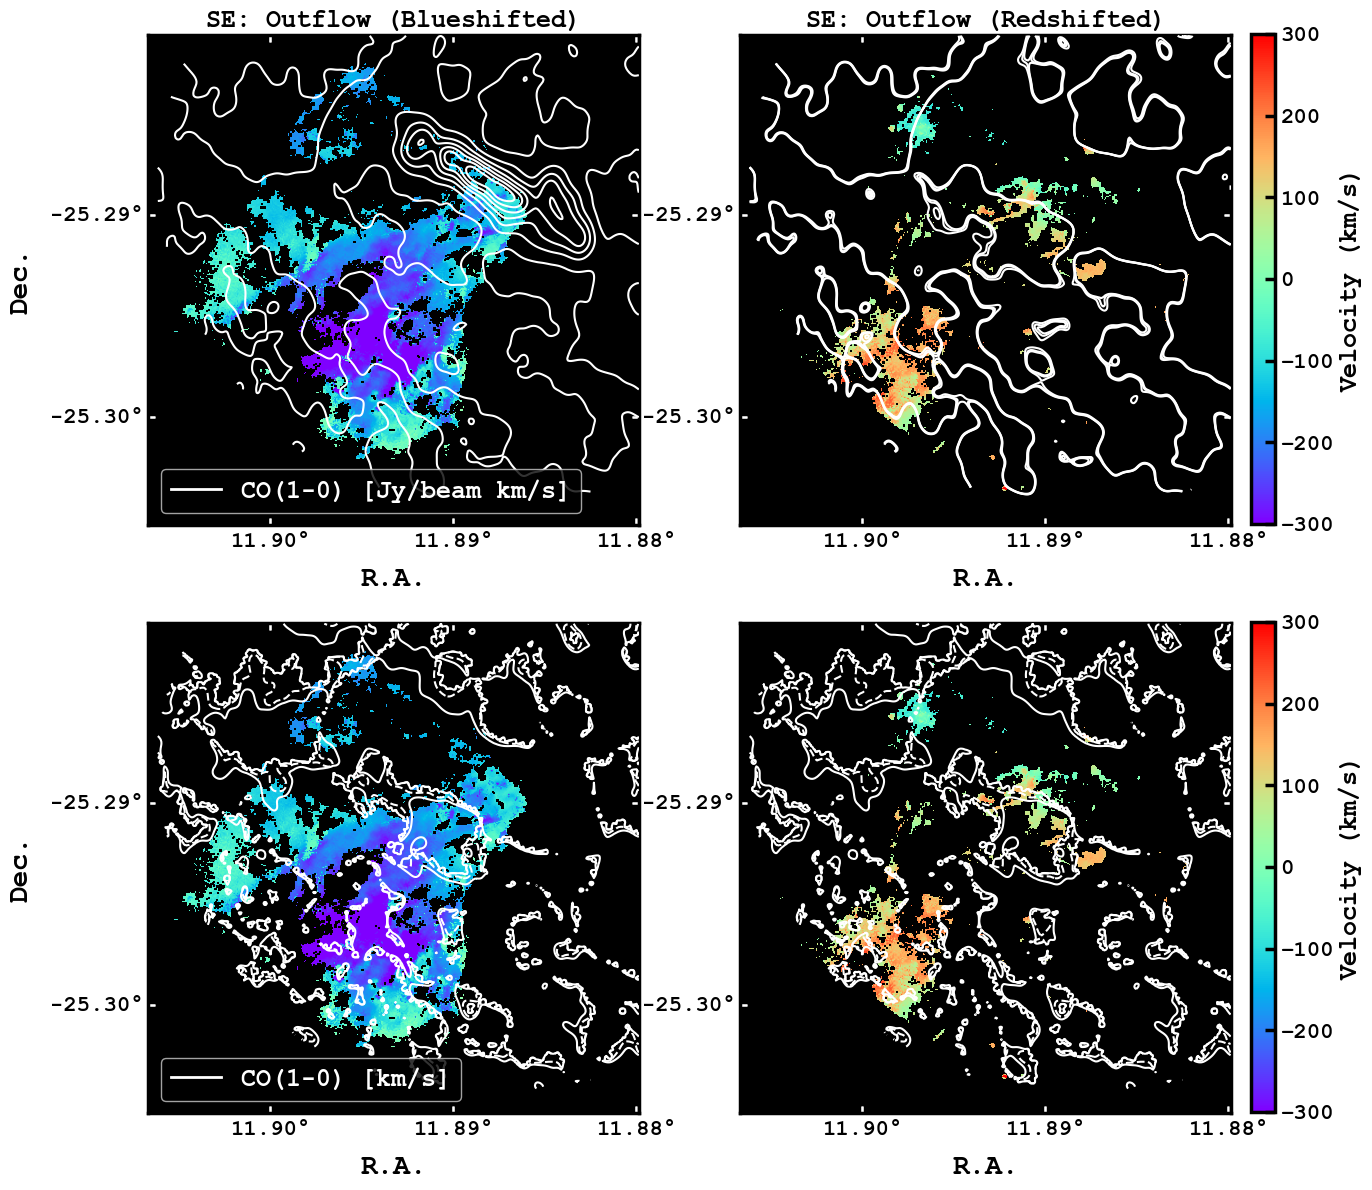

In [33]:
CO_out = SpectralCube.read('../ngc253/data/ngc253_co_comb_mopra_clean_pbcor_RO.fits')
CO_out_wcs = CO_out[0,:,:].wcs
CO_mom0 = CO_out.moment(order=0)  # moment 0
# CO_mom1 = SpectralCube.read('../ngc253/data/ngc253_co_comb_mopra_clean_pbcor_RO.fits.moment.weighted_coord.fits')
CO_mom1 = CO_out.moment(order=1)  # moment 1
CO_mom0_array, _ = reproject_interp((CO_mom0, CO_out_wcs), w, shape_out=(y,x))
CO_mom1_array, _ = reproject_interp((CO_mom1, CO_out_wcs), w, shape_out=(y,x))
CO_mom1_array = CO_mom1_array / 1000

fig = plt.figure(figsize=(14,14))

# BLUESHIFTED OUTFLOW
ax = plt.subplot(2, 2, 1, projection=w)
im = ax.imshow(outflow1_vel, origin='lower', vmin=vmin, vmax=vmax, cmap='rainbow')
ax.set_title('SE: Outflow (Blueshifted)', fontsize=18)
ax.coords[0].set_major_formatter('d.dd')
ax.coords[1].set_major_formatter('d.dd')
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='white')
ax.set_xlabel('R.A.', fontsize=20)
ax.set_ylabel('Dec.', fontsize=20)
ax.set_facecolor("black")
CO_cont = ax.contour(CO_mom0_array, colors='white')
# ax.clabel(CO_cont, fontsize=15, inline=True)
custom_lines = [Line2D([0], [0], color='white', lw=2, ls='-')]
plt.legend(custom_lines,['CO(1-0) [Jy/beam km/s]'], fontsize=18, labelcolor='white', facecolor='black', loc='lower left')

# REDSHIFTED OUTFLOW
ax = plt.subplot(2, 2, 2, projection=w)
im = ax.imshow(outflow2_vel, origin='lower', vmin=vmin, vmax=vmax, cmap='rainbow')
ax.set_title('SE: Outflow (Redshifted)', fontsize=18)
ax.coords[0].set_major_formatter('d.dd')
ax.coords[1].set_major_formatter('d.dd')
ax.coords[1].set_auto_axislabel(False)
ax.set_xlabel('R.A.', fontsize=20)
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='white')
ax.set_facecolor("black")
CO_cont = ax.contour(CO_mom0_array, levels=[250, 500, 1000], colors='white')
cax = ax.inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                             # [x0, y0, width, height] where x0, y0 = lower left corner
bar = fig.colorbar(im, ax=ax, cax=cax)
bar.set_label('Velocity (km/s)', fontsize=18)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

# BLUESHIFTED OUTFLOW
ax1 = plt.subplot(2, 2, 3, projection=w)
im = ax1.imshow(outflow1_vel, origin='lower', vmin=vmin, vmax=vmax, cmap='rainbow')
ax1.coords[0].set_major_formatter('d.dd')
ax1.coords[1].set_major_formatter('d.dd')
ax1.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='white')
ax1.set_xlabel('R.A.', fontsize=20)
ax1.set_ylabel('Dec.', fontsize=20)
ax1.set_facecolor("black")
CO_cont = ax1.contour(CO_mom1_array, vmax=500, vmin=-500, levels=[-100, 100], colors='white')
# ax.clabel(CO_cont, fontsize=15, inline=True)

custom_lines = [Line2D([0], [0], color='white', lw=2, ls='-')]
plt.legend(custom_lines,['CO(1-0) [km/s]'], fontsize=18, labelcolor='white', facecolor='black', loc='lower left')


# REDSHIFTED OUTFLOW
ax = plt.subplot(2, 2, 4, projection=w)
im = ax.imshow(outflow2_vel, origin='lower', vmin=vmin, vmax=vmax, cmap='rainbow')
ax.coords[0].set_major_formatter('d.dd')
ax.coords[1].set_major_formatter('d.dd')
ax.coords[1].set_auto_axislabel(False)
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='white')
ax.set_xlabel('R.A.', fontsize=20)
ax.set_facecolor("black")
CO_cont = ax.contour(CO_mom1_array, vmax=500, vmin=-500, levels=[-100, 100], colors='white')

cax = ax.inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                             # [x0, y0, width, height] where x0, y0 = lower left corner
bar = fig.colorbar(im, ax=ax, cax=cax)
bar.set_label('Velocity (km/s)', fontsize=18)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

# plt.tight_layout()
# plt.savefig('../ngc253/visuals/se_vels.png', dpi=300)
plt.show()


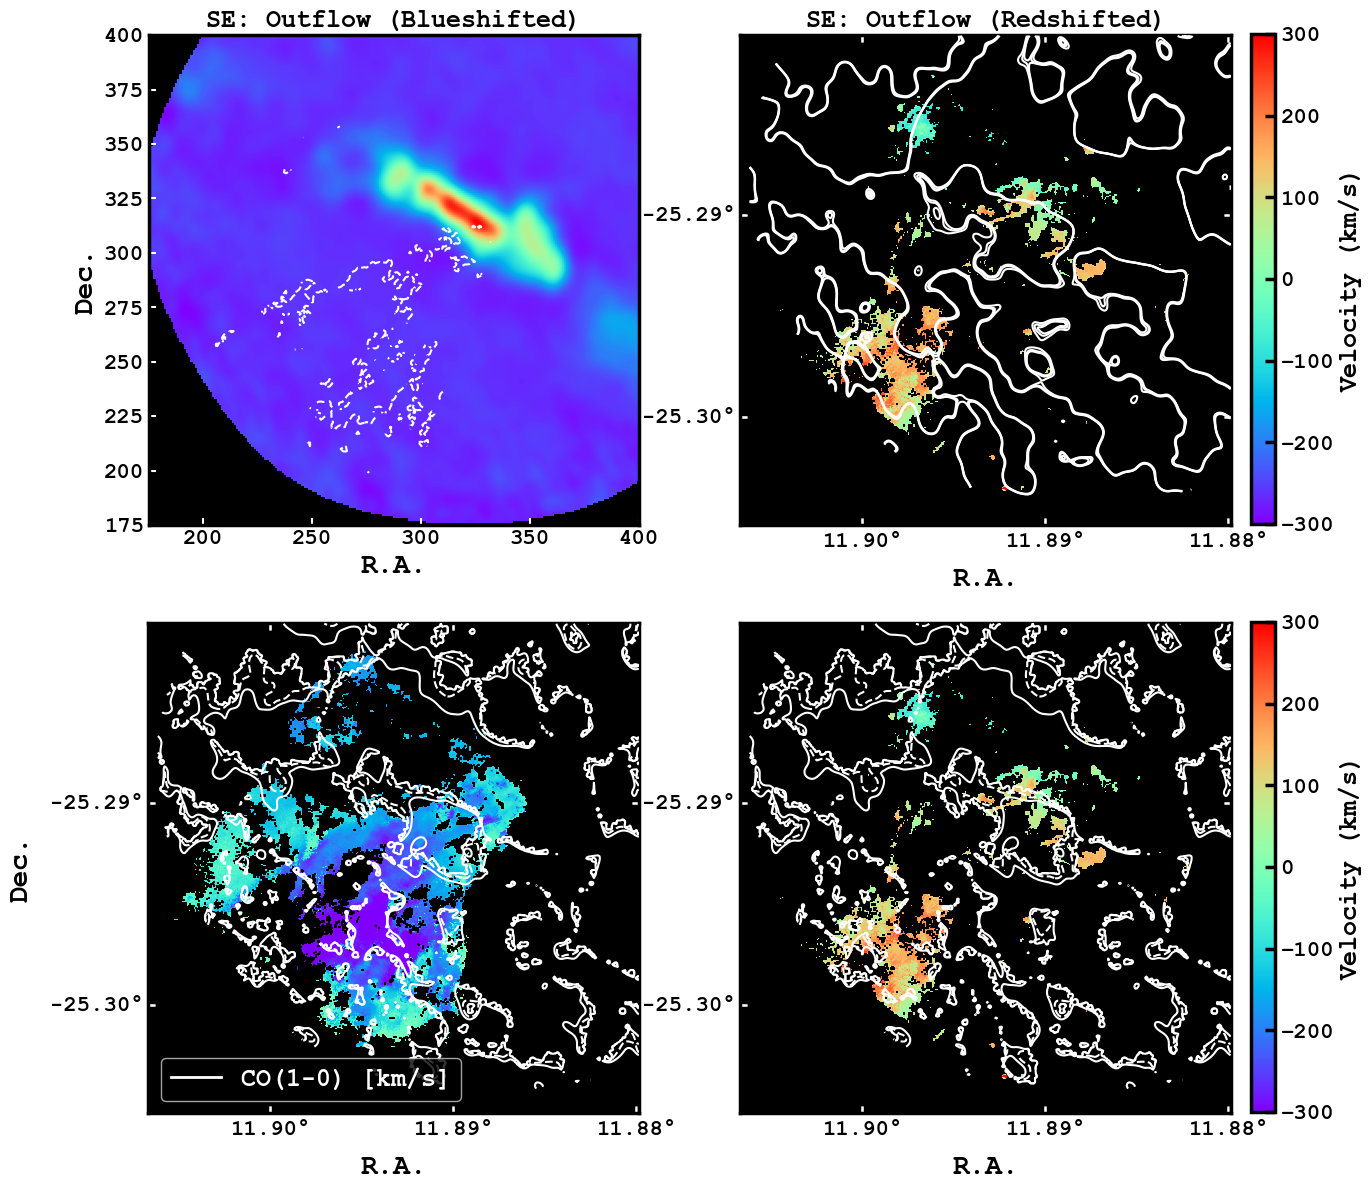

In [34]:
CO = SpectralCube.read('../ngc253/data/ngc253_co_comb_mopra_clean_pbcor_RO.fits')
CO_wcs = CO[0,:,:].wcs
CO_mom0 = CO.moment(order=0)  # moment 0
hduCO = CO_mom0.hdu
outflow1_array, _ = reproject_interp((outflow1_vel, w), CO_wcs, shape_out=(y,x))
outflow2_array, _ = reproject_interp((outflow1_vel, w), CO_wcs, shape_out=(y,x))

fig = plt.figure(figsize=(14,14))

# BLUESHIFTED OUTFLOW
ax = plt.subplot(2, 2, 1)
im = ax.imshow(hduCO.data, origin='lower', cmap='rainbow')
ax.set_title('SE: Outflow (Blueshifted)', fontsize=18)
# ax.coords[0].set_major_formatter('d.dd')
# ax.coords[1].set_major_formatter('d.dd')
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='white')
ax.set_xlabel('R.A.', fontsize=20)
ax.set_ylabel('Dec.', fontsize=20)
ax.set_facecolor("black")
out1_cont = ax.contour(outflow1_array, levels=[-400, -200, 0, 200, 400], colors='white')
# ax.clabel(out1_cont, fontsize=15, inline=True)
plt.xlim(175, 400)
plt.ylim(175, 400)
# custom_lines = [Line2D([0], [0], color='white', lw=2, ls='-')]
# plt.legend(custom_lines,['CO(1-0) [Jy/beam km/s]'], fontsize=18, labelcolor='white', facecolor='black', loc='lower left')

# REDSHIFTED OUTFLOW
ax = plt.subplot(2, 2, 2, projection=w)
im = ax.imshow(outflow2_vel, origin='lower', vmin=vmin, vmax=vmax, cmap='rainbow')
ax.set_title('SE: Outflow (Redshifted)', fontsize=18)
ax.coords[0].set_major_formatter('d.dd')
ax.coords[1].set_major_formatter('d.dd')
ax.coords[1].set_auto_axislabel(False)
ax.set_xlabel('R.A.', fontsize=20)
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='white')
ax.set_facecolor("black")
CO_cont = ax.contour(CO_mom0_array, levels=[250, 500, 1000], colors='white')
cax = ax.inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                             # [x0, y0, width, height] where x0, y0 = lower left corner
bar = fig.colorbar(im, ax=ax, cax=cax)
bar.set_label('Velocity (km/s)', fontsize=18)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

# BLUESHIFTED OUTFLOW
ax1 = plt.subplot(2, 2, 3, projection=w)
im = ax1.imshow(outflow1_vel, origin='lower', vmin=vmin, vmax=vmax, cmap='rainbow')
ax1.coords[0].set_major_formatter('d.dd')
ax1.coords[1].set_major_formatter('d.dd')
ax1.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='white')
ax1.set_xlabel('R.A.', fontsize=20)
ax1.set_ylabel('Dec.', fontsize=20)
ax1.set_facecolor("black")
CO_cont = ax1.contour(CO_mom1_array, vmax=500, vmin=-500, levels=[-100, 100], colors='white')
# ax.clabel(CO_cont, fontsize=15, inline=True)

custom_lines = [Line2D([0], [0], color='white', lw=2, ls='-')]
plt.legend(custom_lines,['CO(1-0) [km/s]'], fontsize=18, labelcolor='white', facecolor='black', loc='lower left')


# REDSHIFTED OUTFLOW
ax = plt.subplot(2, 2, 4, projection=w)
im = ax.imshow(outflow2_vel, origin='lower', vmin=vmin, vmax=vmax, cmap='rainbow')
ax.coords[0].set_major_formatter('d.dd')
ax.coords[1].set_major_formatter('d.dd')
ax.coords[1].set_auto_axislabel(False)
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='white')
ax.set_xlabel('R.A.', fontsize=20)
ax.set_facecolor("black")
CO_cont = ax.contour(CO_mom1_array, vmax=500, vmin=-500, levels=[-100, 100], colors='white')

cax = ax.inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                             # [x0, y0, width, height] where x0, y0 = lower left corner
bar = fig.colorbar(im, ax=ax, cax=cax)
bar.set_label('Velocity (km/s)', fontsize=18)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

# plt.tight_layout()
# plt.savefig('../ngc253/visuals/se_vels.png', dpi=300)
plt.show()


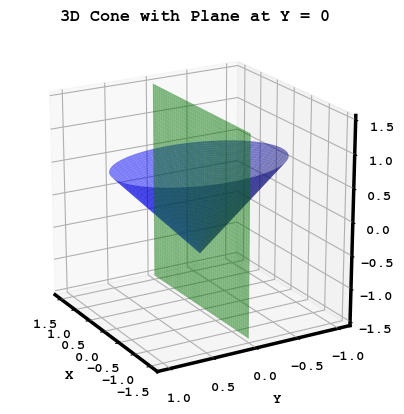

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Cone parameters
opening_angle = 60  # in degrees
inclination = 90 - 75 + 30  # in degrees

# Create a figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Generate points for the cone
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, inclination * np.pi / 180, 50)
U, V = np.meshgrid(u, v)
R = 1 - (V / (inclination * np.pi / 180))
X = R * np.cos(U)
Y = R * np.sin(U)
Z = - V / np.tan(opening_angle * np.pi / 360)

# Calculate translation to center the cone apex at y=0, x=0
translate_x = np.mean(X)
translate_y = np.mean(Y)
translate_z = np.mean(Z)

# Translate the cone coordinates
X -= translate_x
Y -= translate_y
Z -= translate_z

# Plot the cone
ax.plot_surface(X, Y, Z, color='b', alpha=0.5)

# Generate points for the plane at Y = 0
plane_x = np.linspace(-1.5, 1.5, 50)
plane_z = np.linspace(-1.5, 1.5, 50)
plane_X, plane_Z = np.meshgrid(plane_x, plane_z)
plane_Y = np.zeros_like(plane_X)

# Plot the plane at Y = 0
ax.plot_surface(plane_X, plane_Y, plane_Z, color='g', alpha=0.5)

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set Z-axis limits
# ax.set_zlim(0, 1.5)  # Set the lower limit of the Z-axis to 0

# Set plot title
ax.set_title('3D Cone with Plane at Y = 0')

# Set equal aspect ratio for proper visualization
ax.set_box_aspect([1, 1, 1])

# Adjust the view to rotate the plot to show the side of the cone
ax.view_init(elev=20, azim=150)

# Show the plot
plt.show()
